# Cortical Filters
## Visualization of filters and convolutions

In [1]:
from collections import namedtuple
import itertools
import glob
import logging
import os
import random


import argparse
import numpy as np
import pydub
import tensorflow as tf

# from audio_load import load_audio_from_files, audio2spec
from st_2d import scat2d
import windows as win

In [2]:
save_path = '/scratch0/ilya/locDownloads/advaudio_fig/'

In [3]:
from PIL import Image

In [4]:
import imageio

In [5]:
import importlib

In [6]:
importlib.reload(win)

<module 'windows' from '/cfarhomes/ilyak/ilyakavalerov@gmail.com/ramawks69/pyfst/windows.py'>

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import IPython.display as ipd
import librosa.display

In [8]:
# cortical
rv = [4, 8, 16, 32]
sv = [.25, .5, 1, 2, 4, 8]

winobj = win.cortical_psi_factory(rv, sv, 128)
print(winobj.nfilt)

48


In [9]:
from colorsys import hls_to_rgb

def make_color(M):
    return (M - M.min()) / (M.max() - M.min())

def colorize(z):
    # complex to color
    # https://stackoverflow.com/questions/17044052/mathplotlib-imshow-complex-2d-array/36082859
    r = np.abs(z)
    arg = np.angle(z) 

    h = (arg + np.pi)  / (2 * np.pi) + 0.5
    l = 1.0 - 1.0/(1.0 + r**0.3)
    s = 0.8

    c = np.vectorize(hls_to_rgb) (h,l,s) # --> tuple
    c = np.array(c)  # -->  array of (3,n,m) shape, but need (n,m,3)
    c = c.swapaxes(0,2) 
    return c

In [11]:
# iterate in cortical specific way
# 6 x 4, left and right

nrow = 6
ncol = 4

img = np.zeros((2+(winobj.kernel_size[0]+2)*nrow, 2+((winobj.kernel_size[1]+2)*(ncol*2)), 3))
for left_right in range(2):
    for col in range(ncol):
        for row in range(nrow):
            idx = 2*row + col*12 + left_right # even is phase 1
            if left_right == 0:
                x = col
            else:
                x = col + left_right*4
            y = row
            # print('{}x{} is {}'.format(y, x, winobj.filter_params[idx]))
            filt_ = winobj.filters[:,:,idx]
            tmp_img = colorize(filt_)
#             tmp_img = np.expand_dims(np.angle(filt_),-1)
            for chan in range(tmp_img.shape[2]):
                tmp_img[:,:,chan] = (tmp_img[:,:,chan] - tmp_img[:,:,chan].mean()) / (3*tmp_img[:,:,chan].std())
                tmp_img[:,:,chan] /= 2.0
                tmp_img[:,:,chan] += 0.5
                tmp_img[:,:,chan] = np.clip(tmp_img[:,:,chan], 0, 1)
            img[ (y*(winobj.kernel_size[0]+2)+2):((y+1)*(winobj.kernel_size[0]+2)), (x*(winobj.kernel_size[1]+2)+2):((x+1)*(winobj.kernel_size[1]+2)) ] = \
                tmp_img
            


In [13]:
# img_ =  Image.fromarray(np.uint8(img*255))
# img_.putalpha(500)

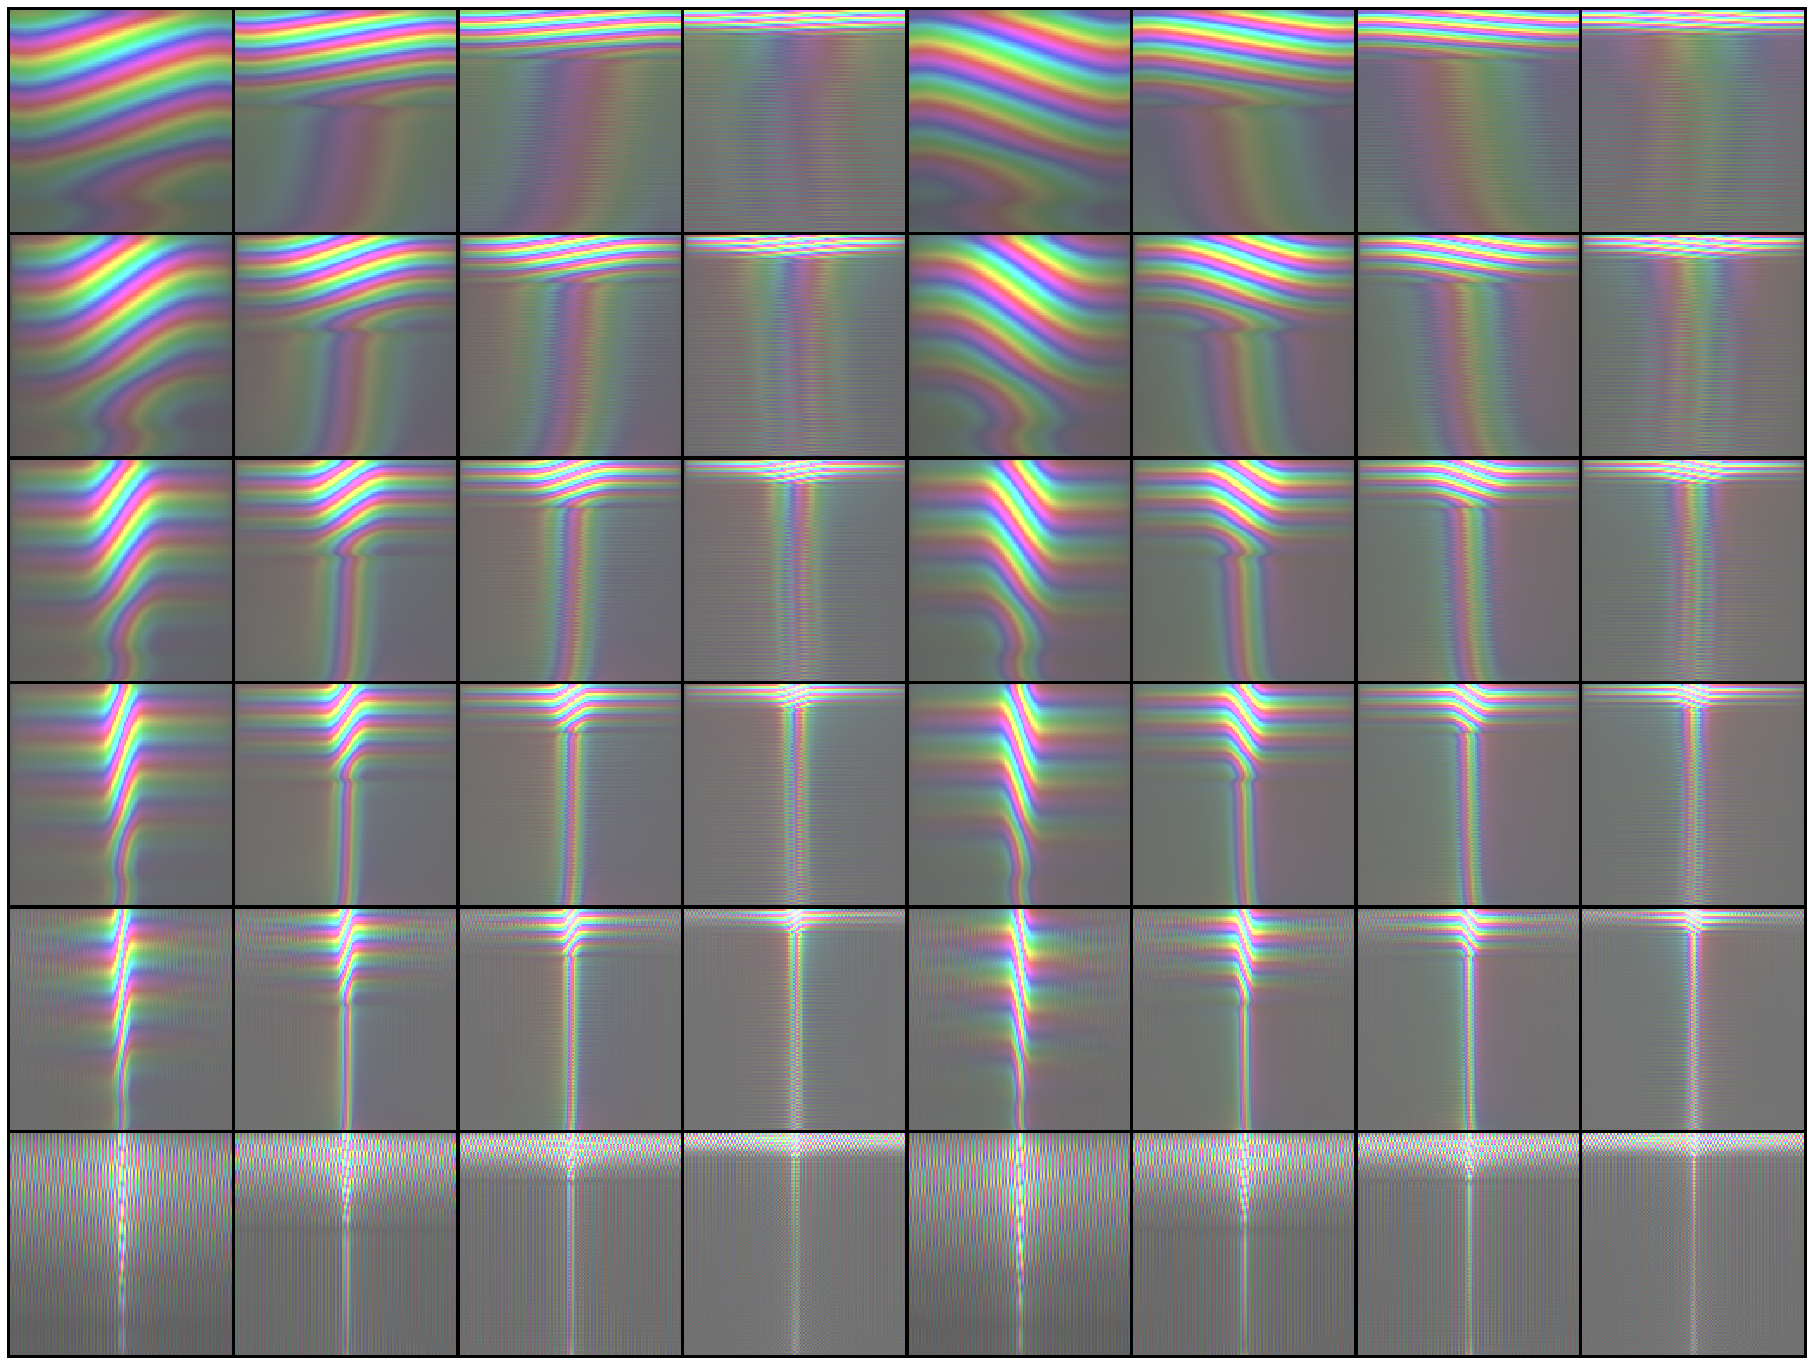

In [14]:
fig = plt.figure()
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
fig.set_figheight(25)
fig.set_figwidth(25)
plt.imshow(img)
# plt.imshow(img[:,:,0], cmap='Greys')

In [15]:
layerO = namedtuple('layerO', ['strides', 'padding'])

## Load data, make lfbe, and see overlap in lfbe space with oracle mask

In [16]:
import soundfile as sf

In [17]:
y, sr = sf.read('/scratch1/ilya/locDoc/data/LibriSpeech/train-clean-100/103/1240/103-1240-0000.flac')
y = np.array(y[7*sr:9*sr])

In [18]:
ipd.Audio(y, rate=16000)

In [19]:
y2, sr = sf.read('/scratch1/ilya/locDoc/data/LibriSpeech/train-clean-100/1263/138246/1263-138246-0000.flac')
y2 = y2[7*sr:9*sr]

In [20]:
ipd.Audio(y2, rate=16000)

In [21]:
from librosa.filters import mel

/scratch0/ilya/locDoc/miniconda2/envs/venvtf1p15nb/lib/python3.6/site-packages/librosa/filters.py:196: FutureWarning: norm=1 behavior will change in librosa 0.8.0. To maintain forward compatibility, use norm='slaney' instead.
  FutureWarning)


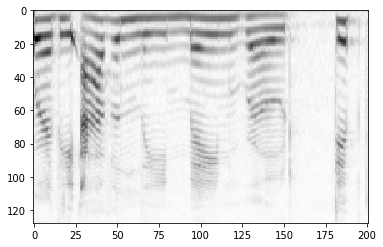

In [22]:
spec = np.abs(librosa.core.stft(np.array(y) / 2.0**15,
        win_length=400,
        hop_length=160,
        n_fft=1024))
A = mel(16000, 1024, n_mels=128, fmin=80, fmax=7200, norm=1)
lfbe = np.dot(A,spec)
plt.imshow(lfbe**0.3, cmap='Greys')

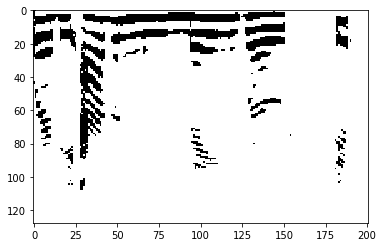

In [23]:
lfbe_mask1 = (20*np.log10(lfbe / lfbe.max()) > -25).astype(int)
plt.imshow(lfbe_mask1, cmap='Greys')

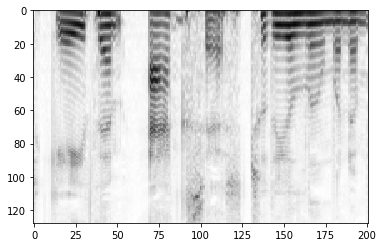

In [24]:
spec = np.abs(librosa.core.stft(np.array(y2) / 2.0**15,
        win_length=400,
        hop_length=160,
        n_fft=1024))
A = mel(16000, 1024, n_mels=128, fmin=80, fmax=7200, norm=1)
lfbe2 = np.dot(A,spec)
plt.imshow(lfbe2**0.3, cmap='Greys')

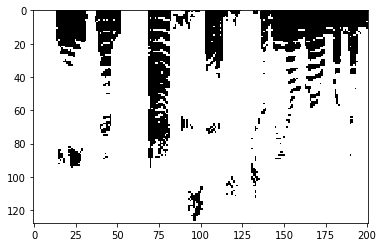

In [25]:
lfbe_mask2 = (20*np.log10(lfbe2 / lfbe2.max()) > -25).astype(int)
plt.imshow(lfbe_mask2, cmap='Greys')

In [26]:
ipd.Audio(y+y2, rate=16000)

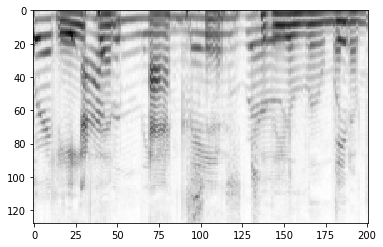

In [27]:
plt.imshow((lfbe+lfbe2)**0.3, cmap='Greys')

In [28]:
oracle_lfbe = (lfbe > lfbe2).astype(int)

7.614928709286018

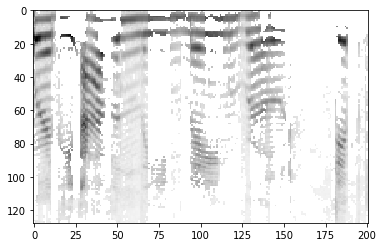

In [77]:
rec = (oracle_lfbe*(lfbe+lfbe2))
plt.imshow(rec**0.3, cmap='Greys')
10*np.log10( ((lfbe)**2).sum() / ((rec - lfbe)**2).sum() ) # SNR

11.73465037925392

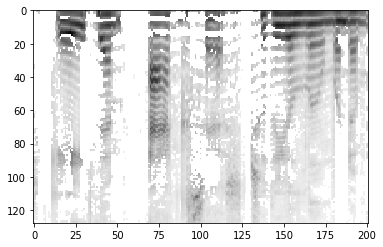

In [76]:
rec = ((1-oracle_lfbe)*(lfbe+lfbe2))
plt.imshow(rec**0.3, cmap='Greys')

10*np.log10( ((lfbe2)**2).sum() /  ((rec - lfbe2)**2).sum() ) # SNR

In [64]:
# intersection over union
(lfbe_mask1*lfbe_mask2).sum() / ((lfbe_mask1+lfbe_mask2) > 0).astype(int).sum()

0.12796208530805686

In [65]:
lfbe.shape

(128, 201)

## Tensorflow Convolution

In [80]:
rv = [4, 8, 16, 32]
sv = [.25, .5, 1, 2, 4, 8]
ncort = len(rv) + 2*len(sv)
l = 32
psi = win.cortical_psi_factory(rv, sv, l)
nrate = len(rv)
nscale = 2*len(sv)
layer_params = layerO((1,1), 'same')

In [81]:
# define the operations
input_spec = tf.placeholder(tf.float32, shape=(1,128,201))
x = tf.expand_dims(input_spec, -1) # batch, freq, time, 1
h = x.shape[1]
w = x.shape[2]

U1 = scat2d(x, psi, layer_params)

### bs, h=freq, w=time, time varying=rate, frequency varying=scale
U1 = tf.reshape(U1, [-1, h, w, nrate, nscale])

### smaller version
### bs, time, rate, scale, freq
# U1 = tf.transpose(U1, [0,2,3,4,1])
# U1_flat = tf.reshape(U1, [-1, nscale, h])
# Cmats_flat = tf.einsum('aij,ajk->aik', U1_flat, tf.transpose(U1_flat, [0,2,1]))
# Cmats = tf.reshape(Cmats_flat, [-1, w, nrate, nscale, nscale])

### larger version, matching Krishnan, Elhilali, Shamma
### bs, time, rate, freq, scale
U1 = tf.transpose(U1, [0,2,3,1,4])
U1_flat = tf.reshape(U1, [-1, h, nscale])
Cmats_flat = tf.einsum('aij,ajk->aik', U1_flat, tf.transpose(U1_flat, [0,2,1]))
Cmats = tf.reshape(Cmats_flat, [-1, w, nrate, h, h])


In [83]:
Cmats.shape

TensorShape([Dimension(1), Dimension(201), Dimension(4), Dimension(128), Dimension(128)])

### Overlap in cortical space

In [84]:
sess = tf.Session()

In [85]:
sess.run(tf.global_variables_initializer())

In [86]:
feed_dict = {input_spec: [lfbe]}

In [87]:
Cmats_np1 = sess.run(Cmats, feed_dict)

In [88]:
Cmats_np2 = sess.run(Cmats, {input_spec: [lfbe2]})

In [89]:
oracle_mask = (Cmats_np1 > Cmats_np2).astype(int)

In [90]:
rec = (oracle_mask*(Cmats_np1+Cmats_np2))
10*np.log10( ((Cmats_np1)**2).sum() / ((rec - Cmats_np1)**2).sum() ) # SNR

8.055624670603844

In [91]:
rec = ((1-oracle_mask)*(Cmats_np1+Cmats_np2))
10*np.log10( ((Cmats_np2)**2).sum() / ((rec - Cmats_np2)**2).sum() ) #SNR

10.601529797721852

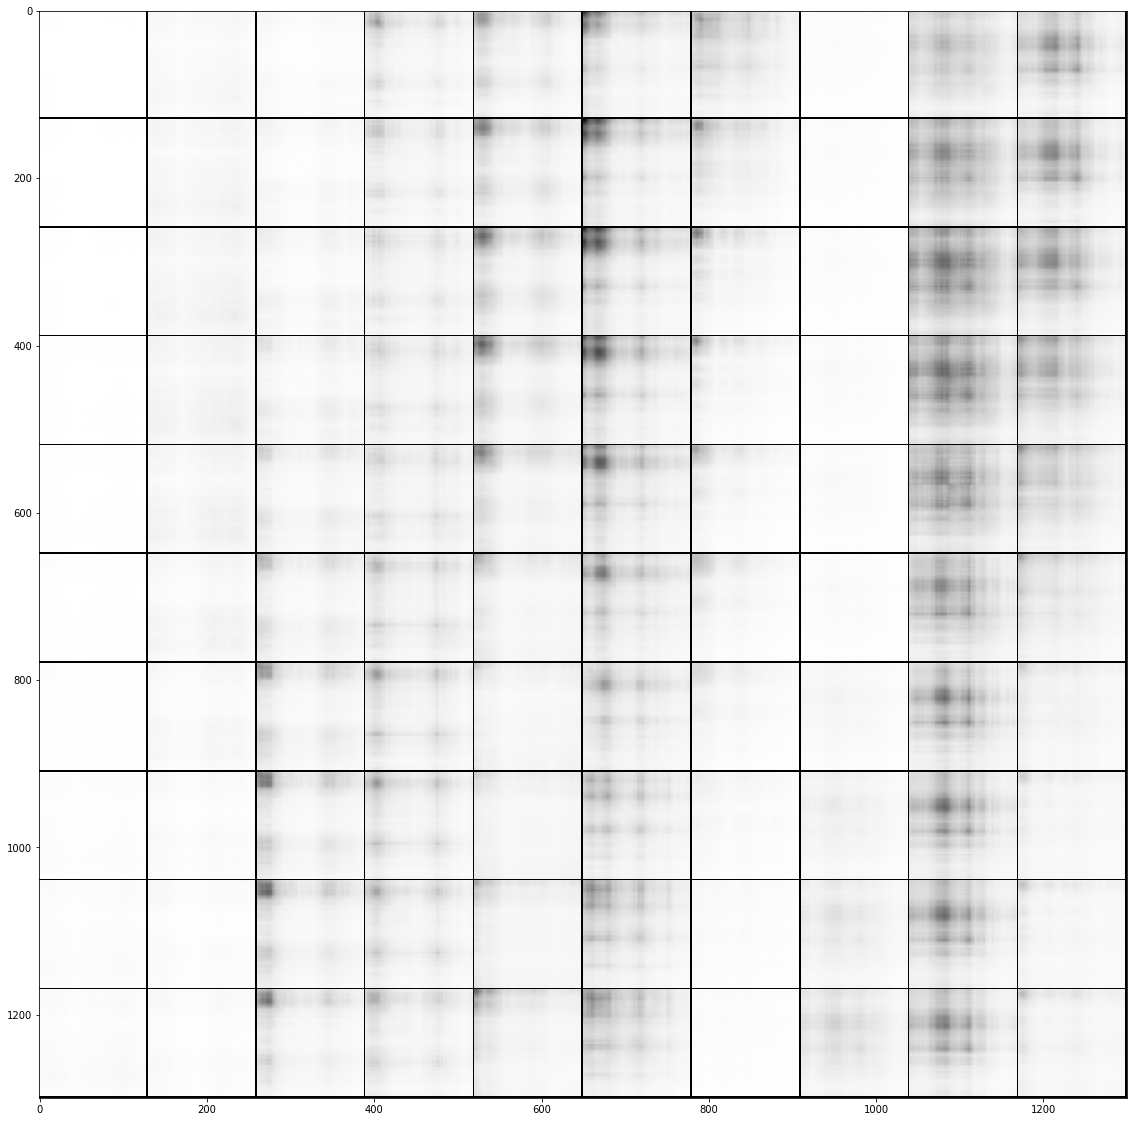

In [123]:
fig, axes = plt.subplots(1,1, figsize=(20,20))
square_ = Cmats_np2[0,:100,3].reshape((10,10,128,128))
square_ = np.pad(square_, ((0,0),(0,0),(0,2),(0,2)), mode='constant', constant_values=square_.max())
square_ = np.concatenate(np.concatenate(square_, axis=-1),axis=0)
axes.imshow(square_**0.3, cmap='Greys')

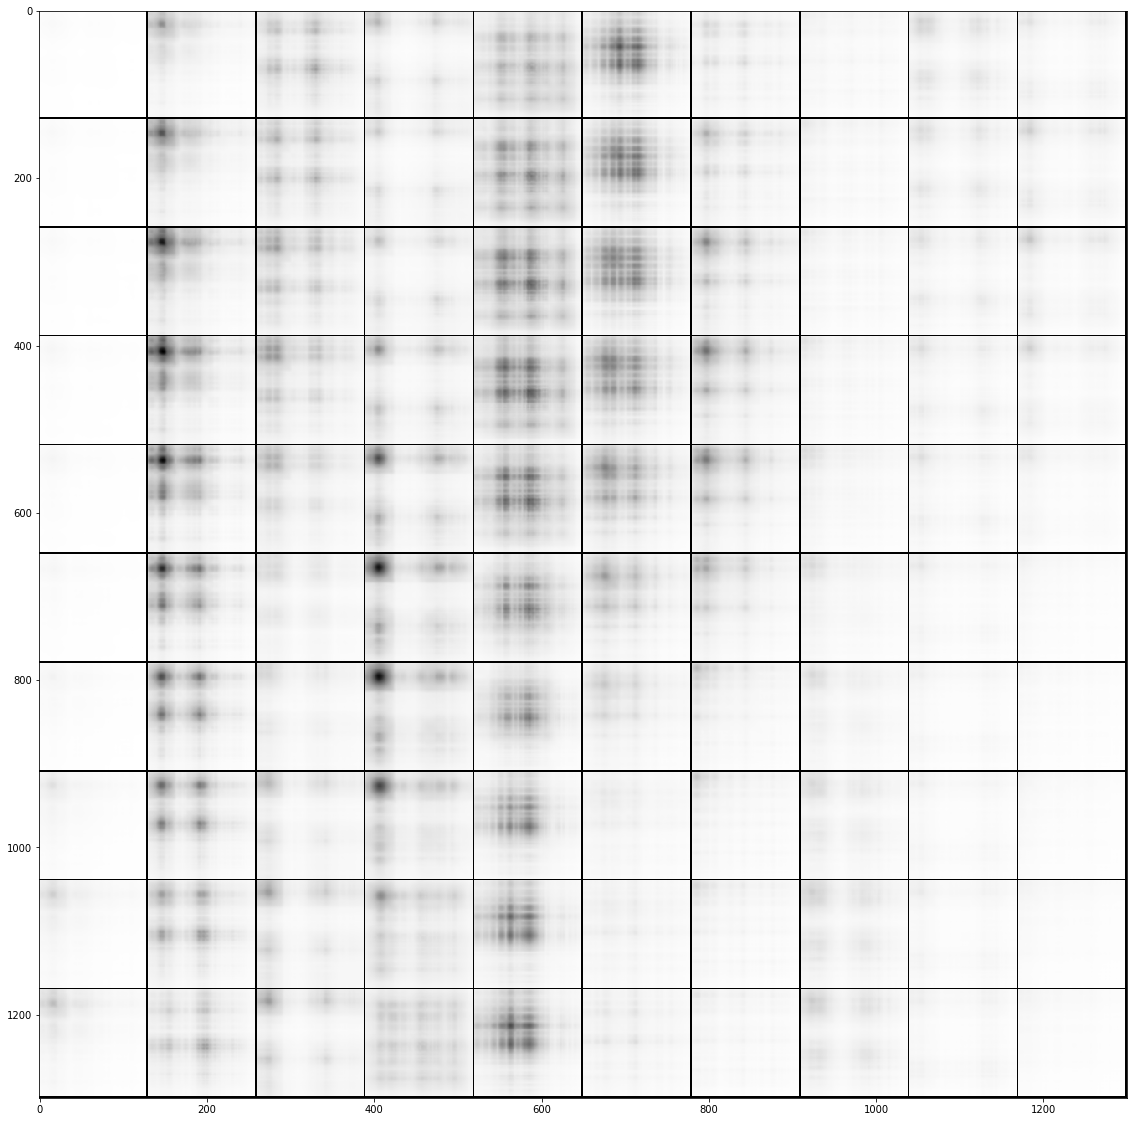

In [124]:
fig, axes = plt.subplots(1,1, figsize=(20,20))
square_ = Cmats_np1[0,:100,3].reshape((10,10,128,128))
square_ = np.pad(square_, ((0,0),(0,0),(0,2),(0,2)), mode='constant', constant_values=square_.max())
square_ = np.concatenate(np.concatenate(square_, axis=-1),axis=0)
axes.imshow(square_**0.3, cmap='Greys')